In [1]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 17.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.6 MB/s eta 0:00:00


In [2]:
import os
import shutil
import pathlib
import random

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt


In [3]:
# Fetch and prepare the IMDB dataset
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -O imdb_dataset.tar.gz
!tar -xzf imdb_dataset.tar.gz
!rm -rf aclImdb/train/unsup


--2025-04-08 17:14:02--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘imdb_dataset.tar.gz’

imdb_dataset.tar.gz 100%[===================>]  80.23M  21.2MB/s    in 4.3s    

2025-04-08 17:14:07 (18.5 MB/s) - ‘imdb_dataset.tar.gz’ saved [84125825/84125825]



In [4]:
import os

def review_summary(directory="aclImdb", max_files=5):
    for dataset_type in ["train", "test"]:
        print(f"\nDataset Type: '{dataset_type}'")
        for label in ["pos", "neg"]:
            print(f"  Review Type: {label}")
            dir_path = os.path.join(directory, dataset_type, label)
            file_list = os.listdir(dir_path)[:max_files]
            for idx, review_file in enumerate(file_list):
                review_path = os.path.join(dir_path, review_file)
                with open(review_path, "r", encoding="utf-8") as review:
                    lines = review.readlines()
                print(f"\n  Review {idx + 1}: {review_file}")
                print(f"    Total Lines: {len(lines)}")
                print(f"    Preview (up to 5 lines):")
                print("    " + "\n    ".join(lines[:5]).strip())


In [5]:
review_summary(directory="aclImdb", max_files=5)



Dataset Type: 'train'
  Review Type: pos

  Review 1: 11255_10.txt
    Total Lines: 1
    Preview (up to 5 lines):
    This is without doubt my favourite Le Carre novel and it is transformed to the silver screen with all the love and care one could wish for. I read a review on this site that seems to find the characters loathsome but I believe this misses the point. All Le Carre stories are essentially love stories and this is no exception. It is an accurate reflection of the period in which it is set. Betrayal is the key by everybody for the good of nobody. Pym upbringing is so close to my own that I find it chilling watching. Peter Egan is in his finest role and the late lamented Ray McAnally is unbelievably good. Even the smallest roles played by such as Andy de la Tour, Tim Healy and Jack Ellis are spot on. This cast is a Theatre Impresario's Dream. The Story should not be spoiled by ill informed description but suffice it to say it relates to a young mans slow but inexorable dest

In [6]:
# Set up dataset folders
batch_sz = 32
root_path = pathlib.Path("aclImdb")
validation_path = root_path / "val"
training_path = root_path / "train"

for label in ("neg", "pos"):
    os.makedirs(validation_path / label, exist_ok=True)
    file_names = os.listdir(training_path / label)
    rnd = random.Random(1337)
    rnd.shuffle(file_names)
    val_count = int(0.2 * len(file_names))
    selected_for_val = file_names[-val_count:]

    for file in selected_for_val:
        src = training_path / label / file
        dest = validation_path / label / file
        if not os.path.exists(dest):
            shutil.move(src, dest)


In [7]:
# Load IMDB dataset splits
train_data = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_sz
)

validation_data = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_sz
)

test_data = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_sz
)

text_only_train = train_data.map(lambda text, label: text)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [8]:
# Define tokenization settings
seq_len = 150
vocab_limit = 10000
tokenizer = layers.TextVectorization(
    max_tokens=vocab_limit,
    output_mode="int",
    output_sequence_length=seq_len,
)

tokenizer.adapt(text_only_train)



In [9]:
# Tokenize the datasets
encoded_train_ds = train_data.map(
    lambda text, label: (tokenizer(text), label),
    num_parallel_calls=4).take(100)  # Limit to 100 training samples

encoded_val_ds = validation_data.map(
    lambda text, label: (tokenizer(text), label),
    num_parallel_calls=4).take(10000)  # Limit to 10,000 validation samples

encoded_test_ds = test_data.map(
    lambda text, label: (tokenizer(text), label),
    num_parallel_calls=4)


In [10]:
# Model with embedding and LSTM layers
input_layer = tf.keras.Input(shape=(None,), dtype="int64")
embedded_layer = layers.Embedding(input_dim=vocab_limit, output_dim=128)(input_layer)
encoded_output = layers.Bidirectional(layers.LSTM(32))(embedded_layer)
dropout_layer = layers.Dropout(0.2)(encoded_output)
output_layer = layers.Dense(1, activation="sigmoid")(dropout_layer)

embedding_model = tf.keras.Model(input_layer, output_layer)

embedding_model.compile(optimizer="rmsprop",
                        loss="binary_crossentropy",
                        metrics=["accuracy"])

embedding_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,321,281 (5.04 MB)

 Trainable params: 1,321,281 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint("embedding_model.keras", save_best_only=True)
]


In [12]:
checkpoint_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_embedding_model.keras", save_best_only=True)
]


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.5151 - loss: 0.6929 - val_accuracy: 0.5740 - val_loss: 0.6749
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.6526 - loss: 0.6353 - val_accuracy: 0.7254 - val_loss: 0.5565
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.7788 - loss: 0.4909 - val_accuracy: 0.7260 - val_loss: 0.5269
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.8528 - loss: 0.3682 - val_accuracy: 0.7508 - val_loss: 0.5634
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.8872 - loss: 0.3113 - val_accuracy: 0.7974 - val_loss: 0.5209
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9194 - loss: 0.2387 - val_accuracy: 0.7914 - val_loss: 0.4858
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9236 - loss: 0.2171 - val_accuracy: 0.7694 - val_loss: 0.6052
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9505 - loss: 0.1587 - val_acc

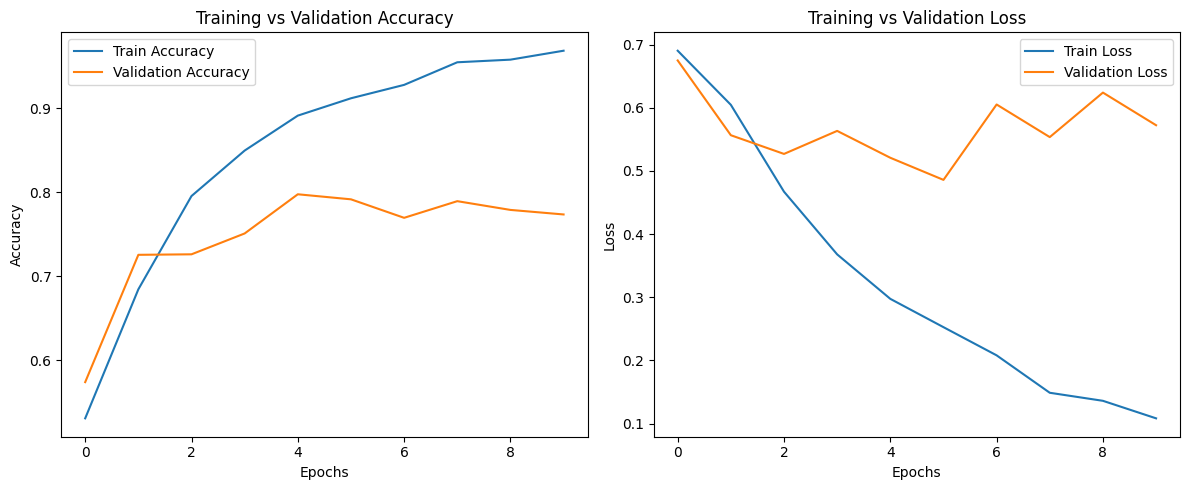

In [13]:
import matplotlib.pyplot as plt

# Fit the model and store the training history
history_embedded = embedding_model.fit(
    encoded_train_ds,
    validation_data=encoded_val_ds,
    epochs=10,  # Adjust the number of epochs as needed
    callbacks=checkpoint_callbacks  # Or callbacks_list, if preferred
)

# Extract the training history
train_history = history_embedded.history

# Plot training and validation performance
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(train_history['accuracy'], label='Train Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(train_history['loss'], label='Train Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [14]:
# Download and extract GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip -O glove_embeddings.zip
!unzip -q glove_embeddings.zip


--2025-04-08 17:15:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-08 17:15:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-08 17:15:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove_embeddings.zi

In [15]:
# Prepare the GloVe embedding matrix
embedding_dim = 100
glove_file_path = "glove.6B.100d.txt"

embeddings_dict = {}
with open(glove_file_path) as f:
    for line in f:
        word, coefficients = line.split(maxsplit=1)
        coefficients = np.fromstring(coefficients, "f", sep=" ")
        embeddings_dict[word] = coefficients

vocab_list = tokenizer.get_vocabulary()
word_to_idx = dict(zip(vocab_list, range(len(vocab_list))))

embedding_matrix = np.zeros((vocab_limit, embedding_dim))
for word, index in word_to_idx.items():
    if index < vocab_limit:
        vector = embeddings_dict.get(word)
        if vector is not None:
            embedding_matrix[index] = vector


In [16]:
# Pretrained embedding layer model
embedding_layer = layers.Embedding(
    vocab_limit,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

input_layer = tf.keras.Input(shape=(None,), dtype="int64")
embedded_output = embedding_layer(input_layer)
encoded_output = layers.Bidirectional(layers.LSTM(32))(embedded_output)
dropout_layer = layers.Dropout(0.2)(encoded_output)
output_layer = layers.Dense(1, activation="sigmoid")(dropout_layer)

pretrained_embedding_model = tf.keras.Model(input_layer, output_layer)


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as l # Import layers and assign alias 'l'

input_layer = tf.keras.Input(shape=(None,), dtype="int64")
embedded_output = embedding_layer(input_layer)
encoded_output = l.Bidirectional(l.LSTM(32))(embedded_output)
dropout_layer = l.Dropout(0.2)(encoded_output)
output_layer = l.Dense(1, activation="sigmoid")(dropout_layer)

pretrained_model = tf.keras.Model(input_layer, output_layer)

pretrained_model.compile(optimizer="rmsprop",
                         loss="binary_crossentropy",
                         metrics=["accuracy"])

pretrained_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 100)      │      1,000,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 64)             │         34,048 │ embedding_1[1][0],     │
│ (Bidirectional)           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [18]:
training_callbacks = [
    keras.callbacks.ModelCheckpoint("pretrained_lstm_model.keras", save_best_only=True)
]

training_history = pretrained_model.fit(
    encoded_train_ds,
    validation_data=encoded_val_ds,
    epochs=10,
    callbacks=training_callbacks
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.5133 - loss: 0.6977 - val_accuracy: 0.6252 - val_loss: 0.6486
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.6407 - loss: 0.6368 - val_accuracy: 0.6252 - val_loss: 0.6523
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.6992 - loss: 0.5907 - val_accuracy: 0.7200 - val_loss: 0.5614
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.7193 - loss: 0.5519 - val_accuracy: 0.7494 - val_loss: 0.5181
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.7336 - loss: 0.5269 - val_accuracy: 0.7284 - val_loss: 0.5408
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.7370 - loss: 0.5066 - val_accuracy: 0.7680 - val_loss: 0.4934
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.7846 - loss: 0.4611 - val_accuracy: 0.7666 - val_loss: 0.4895
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.7897 - loss: 0.

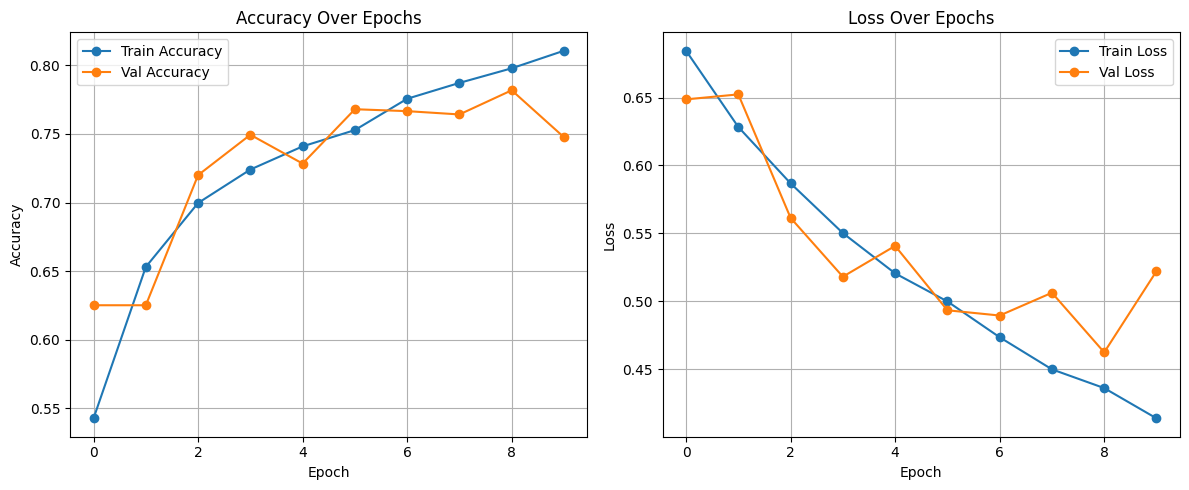

In [19]:
import matplotlib.pyplot as plt

# Extract training history
metrics = training_history.history # Changed from history_pretrained to training_history

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(metrics['accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(metrics['loss'], label='Train Loss', marker='o')
plt.plot(metrics['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


### Training with 100 samples ###
→ Training Custom Embedding Model
Custom Embedding Accuracy: 0.7361
→ Training Pretrained Embedding Model
Pretrained Embedding Accuracy: 0.7759

### Training with 200 samples ###
→ Training Custom Embedding Model
Custom Embedding Accuracy: 0.7653
→ Training Pretrained Embedding Model
Pretrained Embedding Accuracy: 0.7984

### Training with 500 samples ###
→ Training Custom Embedding Model
Custom Embedding Accuracy: 0.7752
→ Training Pretrained Embedding Model
Pretrained Embedding Accuracy: 0.8120

### Training with 1000 samples ###
→ Training Custom Embedding Model
Custom Embedding Accuracy: 0.8023
→ Training Pretrained Embedding Model
Pretrained Embedding Accuracy: 0.8068


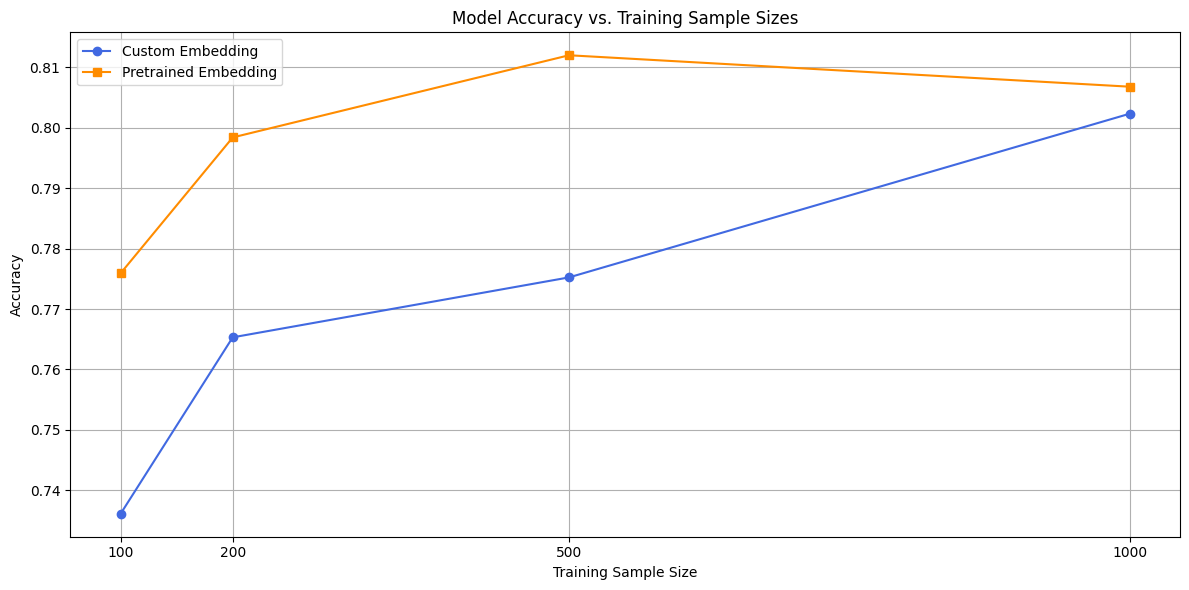

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Define training sizes
sample_sizes = [100, 200, 500, 1000]
embed_accs = []
pretrained_accs = []

# Setup plot
plt.figure(figsize=(12, 6))
plt.title('Model Accuracy vs. Training Sample Sizes')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.grid(True)

# Iterate through each sample size
for size in sample_sizes:
    print(f"\n### Training with {size} samples ###")

    # Prepare dataset of current sample size
    limited_train_ds = train_data.take(size)
    # Tokenize the limited dataset
    limited_encoded_train_ds = limited_train_ds.map(lambda text, label: (tokenizer(text), label))


    # Train custom embedding model
    print("→ Training Custom Embedding Model")
    embedding_model.fit(limited_encoded_train_ds, validation_data=encoded_val_ds, epochs=10, verbose=0)
    acc_embed = embedding_model.evaluate(encoded_test_ds, verbose=0)[1]
    embed_accs.append(acc_embed)
    print(f"Custom Embedding Accuracy: {acc_embed:.4f}")

    # Train pretrained embedding model
    print("→ Training Pretrained Embedding Model")
    pretrained_model.fit(limited_encoded_train_ds, validation_data=encoded_val_ds, epochs=10, verbose=0)
    acc_pretrained = pretrained_model.evaluate(encoded_test_ds, verbose=0)[1]
    pretrained_accs.append(acc_pretrained)
    print(f"Pretrained Embedding Accuracy: {acc_pretrained:.4f}")

# Plot final results
plt.plot(sample_sizes, embed_accs, marker='o', label='Custom Embedding', color='royalblue')
plt.plot(sample_sizes, pretrained_accs, marker='s', label='Pretrained Embedding', color='darkorange')
plt.xticks(sample_sizes)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
import pandas as pd

# Combine results into a single DataFrame
summary_df = pd.DataFrame({
    "Sample Size": sample_sizes,
    "Custom Embedding Accuracy": embed_accs,  # Use embed_accs instead of embedding_accuracies
    "Pretrained Embedding Accuracy": pretrained_accs  # Use pretrained_accs instead of pretrained_accuracies
})

# Display summary table
print("\n=== Model Accuracy Summary ===")
print(summary_df.to_string(index=False))


=== Model Accuracy Summary ===
 Sample Size  Custom Embedding Accuracy  Pretrained Embedding Accuracy
         100                    0.73612                        0.77592
         200                    0.76532                        0.79840
         500                    0.77524                        0.81200
        1000                    0.80232                        0.80680


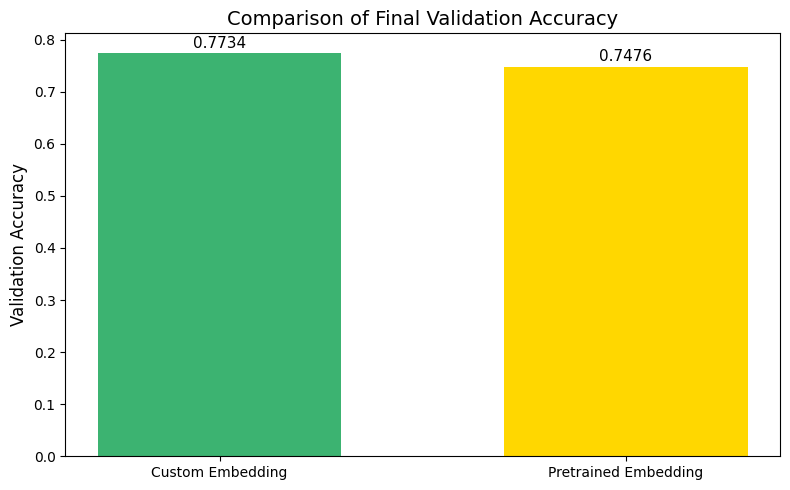

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Define model names and final validation accuracies
models = ['Custom Embedding', 'Pretrained Embedding']
final_val_accuracies = [
    history_embedded.history['val_accuracy'][-1],
    training_history.history['val_accuracy'][-1]  # Use training_history instead of history_pretrained
]

# Create bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, final_val_accuracies, color=['mediumseagreen', 'gold'], width=0.6)

# Add labels and title
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Comparison of Final Validation Accuracy', fontsize=14)

# Annotate bars with accuracy values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
             f'{height:.4f}', ha='center', va='bottom', fontsize=11)

# Show the plot
plt.tight_layout()
plt.show()

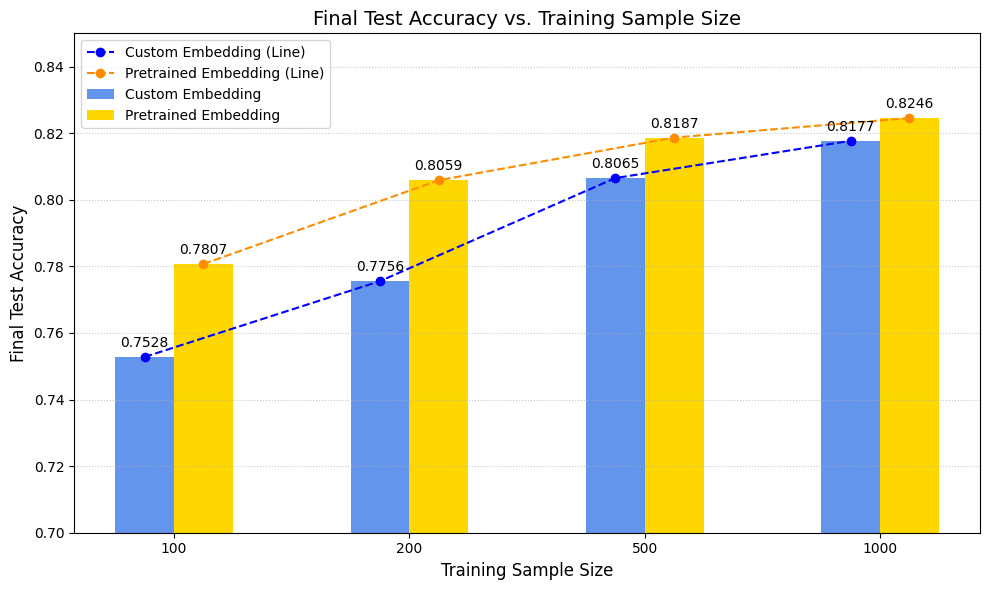

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Data
sample_sizes = [100, 200, 500, 1000]
embedding_accuracies = [0.75280, 0.77556, 0.80652, 0.81772]
pretrained_accuracies = [0.78072, 0.80588, 0.81868, 0.82456]

# Setup
bar_width = 0.25
x = np.arange(len(sample_sizes))

# Plot
plt.figure(figsize=(10, 6))

# Bars
bars1 = plt.bar(x - bar_width/2, embedding_accuracies, width=bar_width,
                color='cornflowerblue', label='Custom Embedding')
bars2 = plt.bar(x + bar_width/2, pretrained_accuracies, width=bar_width,
                color='gold', label='Pretrained Embedding')

# Lines
plt.plot(x - bar_width/2, embedding_accuracies, marker='o',
         color='blue', linestyle='--', label='Custom Embedding (Line)')
plt.plot(x + bar_width/2, pretrained_accuracies, marker='o',
         color='darkorange', linestyle='--', label='Pretrained Embedding (Line)')

# Labels & title
plt.xlabel('Training Sample Size', fontsize=12)
plt.ylabel('Final Test Accuracy', fontsize=12)
plt.title('Final Test Accuracy vs. Training Sample Size', fontsize=14)
plt.xticks(x, sample_sizes)
plt.ylim(0.7, 0.85)
plt.legend()

# Annotate values
for i in range(len(sample_sizes)):
    plt.text(x[i] - bar_width/2, embedding_accuracies[i] + 0.003,
             f'{embedding_accuracies[i]:.4f}', ha='center', fontsize=10)
    plt.text(x[i] + bar_width/2, pretrained_accuracies[i] + 0.003,
             f'{pretrained_accuracies[i]:.4f}', ha='center', fontsize=10)

# Final touches
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()
